# Final project for Artificial Intelligence and Machine Learning Course at Univeristy of Chicago

Goal of our project is to predict future REIT performance through stock data, real estate data and news article sentiment analysis. For the scope of this analysis, we will focus on the office sector within REITs as a way of narrowing our scope. 

By Cameron Keith and Jonathan Ling (August 2023)

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

In [48]:
# Read in Green Street data
df = pd.read_excel('Green Street REIT Data.xlsx')
print(df.shape)
df.head()

(29774, 227)


,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_auto_exemption_points,cg_wme_veto_points,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score
0,1988-10-24,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-10-24,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-10-24,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-10-24,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1988-10-24,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], format='%b-%y').dt.to_period('M')
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month # our data is monthly frequency

In [93]:
df.head()

,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score,year,month
0,1988-10,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
1,1988-10,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
2,1988-10,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
3,1988-10,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
4,1988-10,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10


In [132]:
# Let's drop descriptive features that won't help our model
drop_list = ['comp_id','sector_id','sector_pm1_id','date_bom','date_bs',
             'date_eom','date_last_published','date_mrpo','date_price','ticker_bb',
             'currency_symbol','sector_abbr','sector_pm1','sector_rt','initial1','initial2']

df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(drop_list, axis=1)

In [133]:
# Since we have a very wide dataset, we are going to focus on some features that
# should impact the sector/performance (utilizing Jonathan's industry knowledge)

testing_vars = ['date','year','month','symbol','price','dividend_yield','cash','nav_premium',
                'noi','capex_reserve', 'caprate_nominal_implied','shares']

df_testing = df_cleaned.loc[df_cleaned['sector'] == 'Office'] # focus on office sector
df_testing = df_testing[testing_vars]
df_testing.head()

,date,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,shares
1352,1993-01,1993,1,RCP,8.38,NaN,NaN,-0.301667,NaN,NaN,NaN,37510.0
1370,1993-02,1993,2,CRE,24.25,NaN,NaN,0.154762,NaN,NaN,NaN,13087.0
1388,1993-02,1993,2,RCP,9.50,NaN,NaN,-0.208333,NaN,NaN,NaN,37510.0
1406,1993-03,1993,3,CRE,26.00,0.065,NaN,0.106383,NaN,NaN,NaN,13232.0
1424,1993-03,1993,3,RCP,9.13,0.110,NaN,-0.239167,NaN,NaN,NaN,37510.0


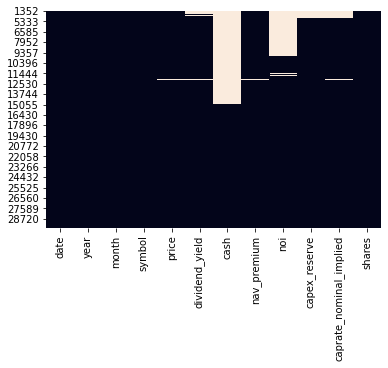

In [134]:
# Visualize where null values exist in our dataset
sns.heatmap(df_testing.isnull(), cbar=False)
plt.show()

Our dataset is pretty good, but cash and noi are two fields that have mor missing values. We will need to analyse to see why these are missing (panel nonresponse/time series gaps).

In [154]:
# Edits to dataframe for our analysis
df_office = df_testing.copy()
df_office = df_office.set_index('date')

# Transformations
df_office['price_pct'] = df_office.price.groupby(df_office['symbol']).pct_change()
df_office['cash_log'] = df_office.cash.groupby(df_office['symbol']).diff()
df_office['noi_dif'] = df_office.noi.groupby(df_office['symbol']).diff()
df_office['marketcap'] = df_office['price']*df_office['shares']

df_office = df_office.loc[df_office['year'] >= 2012] #filter past 2012, to match sentiment data
df_office.head()

,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,shares,price_pct,cash_log,noi_dif,marketcap
date,,,,,,,,,,,,,,,
2012-01,2012,1,BXP,101.32,0.021713,1099783.0,0.066526,1.170438e+06,0.138359,0.049141,168267.0,0.082826,0.0,-0.013053,17048812.44
2012-01,2012,1,CUZ,6.59,0.027314,5634.0,-0.287568,1.041740e+05,0.230453,0.082955,103714.0,0.126496,0.0,0.000000,683475.26
2012-01,2012,1,HIW,29.95,0.056761,34318.0,-0.018033,3.324460e+05,0.191745,0.076494,76489.0,0.045375,0.0,0.000000,2290845.55
2012-01,2012,1,KRC,38.24,0.036611,78481.0,-0.055802,2.556130e+05,0.242399,0.060753,61017.0,0.076880,0.0,0.000000,2333290.08
2012-01,2012,1,WRE,27.78,0.062455,40751.0,-0.111040,1.897160e+05,0.155351,0.066846,66066.0,0.036567,0.0,0.000000,1835313.48


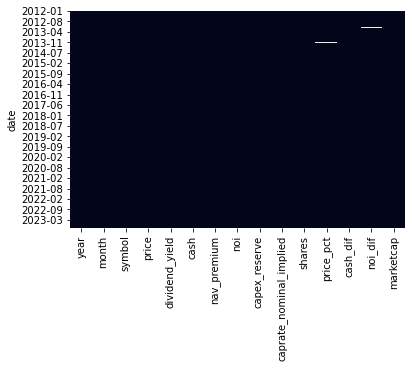

In [137]:
# View nulls
sns.heatmap(df_office.isnull(), cbar=False)
plt.show()

As we can see now, nealry all of our null values were from earlier dates. With our filter after 2012 (to match our sentiment data) we have a complete dataset. We can safely drop the small amount of missing data. 

In [147]:
df_office = df_office.dropna()

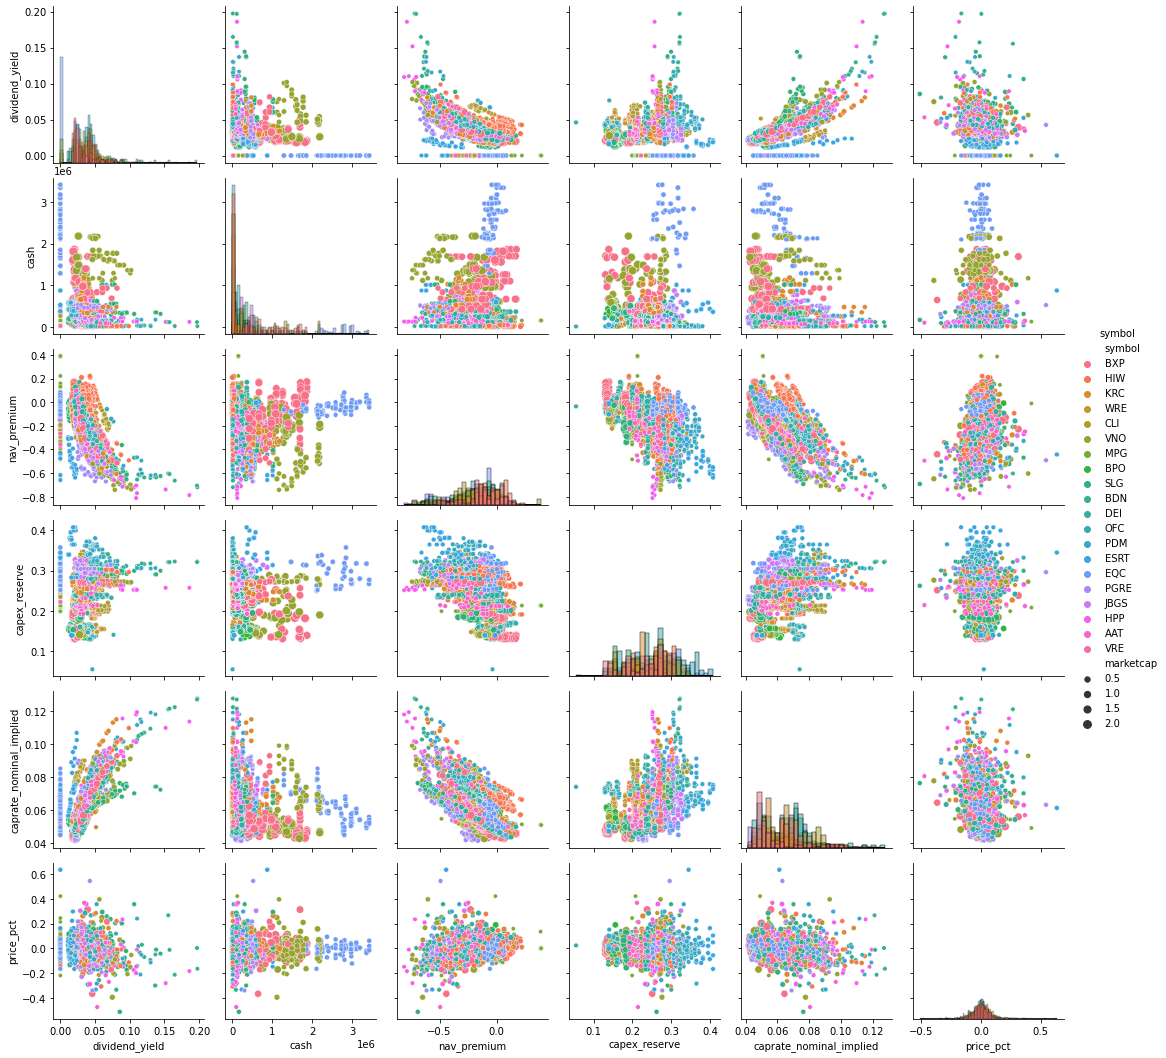

In [239]:
# Chart to analyze feature relationships
feature_list = ['symbol','dividend_yield','cash','nav_premium','capex_reserve','caprate_nominal_implied','price_pct']
ax = sns.PairGrid(df_office.filter(items=feature_list), hue='symbol')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot, size=df_office['marketcap'])
ax.add_legend()

In [185]:
# We have a large outlier (CUZ) due to a reverse stock split, which distorts our price. 
# As a simple fix, we will drop this REIT from our analysis.
df_office = df_office.loc[df_office['symbol'] != 'CUZ'] # focus on office sector


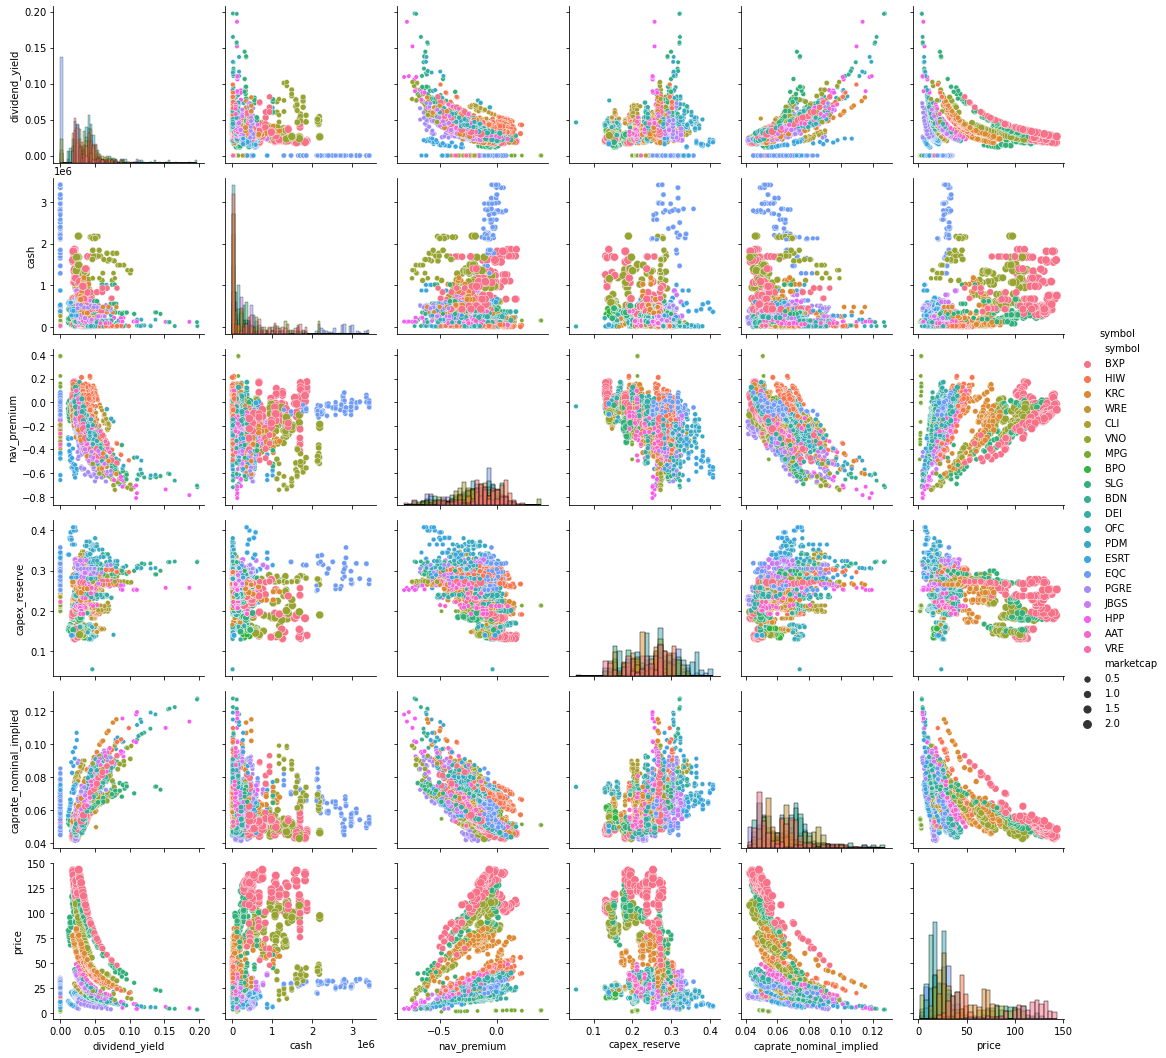

In [186]:
feature_list = ['symbol','dividend_yield','cash','nav_premium','capex_reserve','caprate_nominal_implied','price']
ax = sns.PairGrid(df_office.filter(items=feature_list), hue='symbol')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot, size=df_office['marketcap'])
ax.add_legend()

In [240]:
df_office.head()

,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,shares,price_pct,cash_log,noi_dif,marketcap
date,,,,,,,,,,,,,,,
2012-01,2012,1,BXP,101.32,0.021713,1099783.0,0.066526,1.170438e+06,0.138359,0.049141,168267.0,0.082826,0.0,-0.013053,17048812.44
2012-01,2012,1,HIW,29.95,0.056761,34318.0,-0.018033,3.324460e+05,0.191745,0.076494,76489.0,0.045375,0.0,0.000000,2290845.55
2012-01,2012,1,KRC,38.24,0.036611,78481.0,-0.055802,2.556130e+05,0.242399,0.060753,61017.0,0.076880,0.0,0.000000,2333290.08
2012-01,2012,1,WRE,27.78,0.062455,40751.0,-0.111040,1.897160e+05,0.155351,0.066846,66066.0,0.036567,0.0,0.000000,1835313.48
2012-01,2012,1,CLI,26.40,0.068182,15854.0,-0.234783,4.273600e+05,0.197994,0.089249,100012.0,0.049702,0.0,0.000000,2640316.80


In [ ]:
# Merge dataset with sentiment analysis

In [209]:
# List containing our unique REITs
reits = df_office.symbol.unique()
reits

array(['BXP', 'HIW', 'KRC', 'WRE', 'CLI', 'VNO', 'MPG', 'BPO', 'SLG',
       'BDN', 'DEI', 'OFC', 'PDM', 'ESRT', 'EQC', 'PGRE', 'JBGS', 'HPP',
       'AAT', 'VRE'], dtype=object)

In [215]:
# Create train/test datasets
from sklearn.model_selection import ShuffleSplit

def splitdata(df):
    splitter = ShuffleSplit(test_size=.2, n_splits=2, random_state = 0)
    split = splitter.split(df)
    train_inds, test_inds = next(split)

    train = df.iloc[train_inds]
    test = df.iloc[test_inds]
    
    return(train,test)

In [288]:
# OLS regression
import numpy as np
from patsy import dmatrices
from statsmodels.regression import linear_model

def regress_ols(train, test):
    expr = 'price ~ nav_premium + dividend_yield + caprate_nominal_implied'

    y_train, x_train = dmatrices(expr, train, return_type='dataframe')
    y_test, x_test = dmatrices(expr, test, return_type='dataframe')

    olsr_results = linear_model.OLS(y_train, x_train).fit()
    y_train_pred = olsr_results.predict(x_train)
    y_test_pred = olsr_results.predict(x_test)

    return(olsr_results, y_train, y_train_pred, y_test, y_test_pred)

In [337]:
# Attempt OLS regression for all office REITs

models = []
arimas = []

for i in reits:
    df_reg = df_office.loc[df_office['symbol'] == i] # filter df
    train,test = splitdata(df_reg)
    models.append(regress_ols(train, test))


In [338]:
# Highlight r-squared for each OLS model
rsquared = []

for i in models:
    rsquared.append(i[0].rsquared)
    
results

[0.8074316877855221,
 0.9032130970930502,
 0.766739538467037,
 0.8315568879087087,
 0.7641290744847072,
 0.8997367996612543,
 0.950475211464981,
 0.9966324470709251,
 0.9259931391943902,
 0.8467822320709939,
 0.7254623304135154,
 0.8396140628234128,
 0.8861957189806178,
 0.9023147176920113,
 0.22593563370720204,
 0.9739193473393439,
 0.9415353337796902,
 0.9689950840529554,
 0.9175712497120888,
 1.0]

Text(0, 0.5, 'Price')

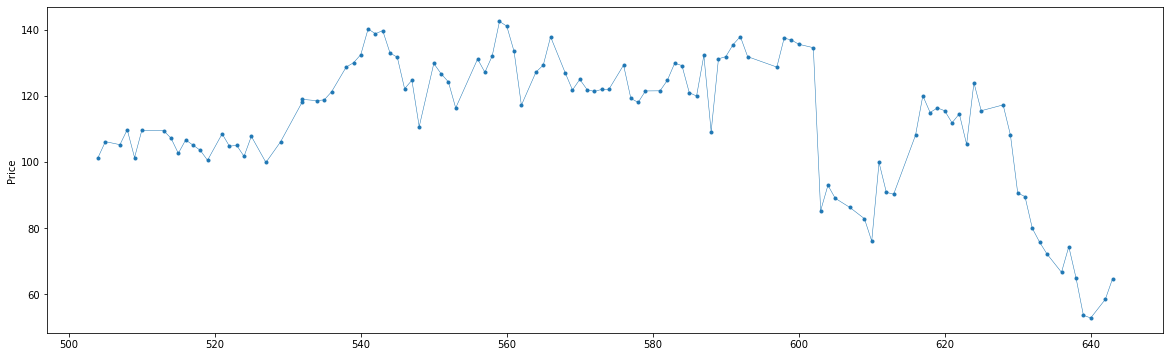

In [346]:
# Let's look at our data for a single REIT (BXP Example)
y_train = models[0][1].sort_index()
y_train.index = y_train.index.astype(int)

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train,marker='.', linestyle='-', linewidth=0.5)
ax.set_ylabel('Price')

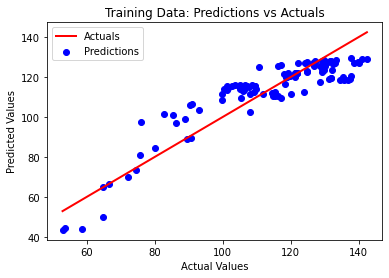

In [340]:
# Plot results for one model to view results
import matplotlib.pyplot as plt

y_train = models[0][1].sort_index()
y_train_pred = models[0][2].sort_index()

plt.scatter(y_train, y_train_pred, color='blue', label='Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2, label='Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data: Predictions vs Actuals')
plt.legend()
plt.show()

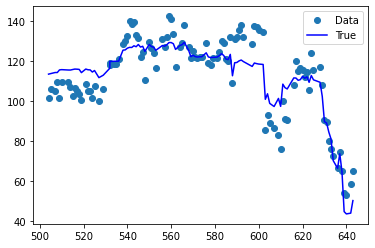

In [345]:
# Plot results for one model to view results
import matplotlib.pyplot as plt

y_train = models[0][1].sort_index()
y_train_pred = models[0][2].sort_index()

y_train.index = y_train.index.astype(int)
y_train_pred.index = y_train_pred.index.astype(int)

fig, ax = plt.subplots()
ax.plot(y_train.index, y_train, "o", label = "Data")
ax.plot(y_train_pred.index, y_train_pred, "b-", label = "True")
ax.legend(loc="best")

In [347]:
print(models[0][0].summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     150.9
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.75e-38
Time:                        17:38:46   Log-Likelihood:                -404.98
No. Observations:                 112   AIC:                             818.0
Df Residuals:                     108   BIC:                             828.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 